In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import entropy, pearsonr
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)

    columns_dict = {
        "FSO_Att": "FSO_Att",
        "RFL_Att": "RFL_Att",
        "AbsoluteHumidity": "AH",
        "AbsoluteHumidityMax": "AH_Max",
        "AbsoluteHumidityMin": "AH_Min",
        "Distance": "Dist",
        "Frequency": "Freq",
        "Particulate": "Part",
        "ParticulateMax": "Part_Max",
        "ParticulateMin": "Part_Min",
        "RainIntensity": "RainInt",
        "RainIntensityMax": "RainInt_Max",
        "RainIntensityMin": "RainInt_Min",
        "RelativeHumidity": "RH",
        "SYNOPCode": "SYNOPCode",
        "Temperature": "Temp",
        "TemperatureDifference": "TDiff",
        "TemperatureMax": "Temp_Max",
        "TemperatureMin": "Temp_Min",
        "Time": "Time",
        "Visibility": "Visi",
        "VisibilityMax": "Visi_Max",
        "VisibilityMin": "Visi_Min",
        "WindDirection": "WD",
        "WindSpeed": "WS",
        "WindSpeedMax": "WS_Max",
        "WindSpeedMin": "WS_Min"
    }
    data.rename(columns=columns_dict, inplace=True)

    # Define categorical and numerical features
    categorical_features = ['Freq', 'Time', 'SYNOPCode']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['FSO_Att', 'RFL_Att']]

    # Handle missing values
    data = data.dropna()

    # Handle outliers for numerical columns using RobustScaler
    scaler = RobustScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    return data, categorical_features, numerical_features

# Function to calculate entropy
def calculate_entropy(data, bin_size):
    counts, _ = np.histogram(data, bins=np.arange(min(data), max(data) + bin_size, bin_size))
    probabilities = counts / np.sum(counts)
    return entropy(probabilities, base=2)

# Function to calculate joint entropy
def calculate_joint_entropy(data1, data2, bin_size):
    joint_counts, _, _ = np.histogram2d(data1, data2, bins=[np.arange(min(data1), max(data1) + bin_size, bin_size),
                                                              np.arange(min(data2), max(data2) + bin_size, bin_size)])
    joint_probabilities = joint_counts / np.sum(joint_counts)
    return entropy(joint_probabilities.flatten(), base=2)

# Function to calculate mutual information
def calculate_mutual_information(measured_rfl, measured_fso, bin_size):
    # Calculate entropies
    HE = calculate_entropy(measured_rfl, bin_size)
    HO = calculate_entropy(measured_fso, bin_size)
    HEO = calculate_joint_entropy(measured_rfl, measured_fso, bin_size)

    # Calculate mutual information
    IEO = HE + HO - HEO

    IEO_over_HEO = IEO / HEO if HEO > 0 else 0

    return HE, HO, HEO, IEO, IEO_over_HEO

# Load and preprocess the data
from google.colab import drive
drive.mount('/content/drive')

data, categorical_features, numerical_features = load_and_preprocess_data('/content/drive/MyDrive/data/RFLFSODataFull.csv')

# Split the data into training, validation, and testing sets
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

X_train, X_temp, y_train_fso, y_temp_fso, y_train_rfl, y_temp_rfl = train_test_split(X, y_fso, y_rfl, test_size=0.3, random_state=42)
X_val, X_test, y_val_fso, y_test_fso, y_val_rfl, y_test_rfl = train_test_split(X_temp, y_temp_fso, y_temp_rfl, test_size=0.5, random_state=42)

# Exclude 'Freq' from the FSO dataset
X_train_fso = X_train.drop(columns=['Freq'])
X_val_fso = X_val.drop(columns=['Freq'])
X_test_fso = X_test.drop(columns=['Freq'])

test_rfl_subsets = {}
test_fso_subsets = {}

# Prepare to store results for each bin size
results_1 = {
    "Weather": [],
    "rEO": [],
    "HE": [],
    "HO": [],
    "HEO": [],
    "IEO": [],
    "IEO/HEO": []
}

results_2 = {
    "Weather": [],
    "rEO": [],
    "HE": [],
    "HO": [],
    "HEO": [],
    "IEO": [],
    "IEO/HEO": []
}

# Define weather conditions and bin sizes
synop_codes_order = [0, 3, 4, 5, 6, 7, 8]

# Weather condition mapping
synopcode_to_weather = {
    0: 'Clear Weather',
    3: 'Dust storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

# Bin sizes
bin_sizes = [0.1, 2.0]

# Splitting test datasets by SYNOP code
for synop_code in synop_codes_order:
    test_rfl_subsets[synop_code] = X_test[X_test['SYNOPCode'] == synop_code]

for synop_code in synop_codes_order:
    test_fso_subsets[synop_code] = X_test_fso[X_test_fso['SYNOPCode'] == synop_code]

# Calculate values for each SYNOP code and bin size
for synop_code in synop_codes_order:
    if not test_rfl_subsets[synop_code].empty:
        #test data
        test_rfl = y_test_rfl[test_rfl_subsets[synop_code].index]
        test_fso = y_test_fso[test_fso_subsets[synop_code].index]


        # Calculate Pearson correlation for measured data
        rEO, _ = pearsonr(test_rfl, test_fso)

        # Calculate for 0.1 dB
        results = calculate_mutual_information(
            test_rfl, test_fso,
            0.1
        )
        weather_condition = synopcode_to_weather[synop_code]
        results_1["Weather"].append(weather_condition)
        results_1["rEO"].append(round(rEO, 3))  # Store measured correlation and round to 3 decimal places
        results_1["HE"].append(round(results[0], 3))
        results_1["HO"].append(round(results[1], 3))
        results_1["HEO"].append(round(results[2], 3))
        results_1["IEO"].append(round(results[3], 3))
        results_1["IEO/HEO"].append(round(results[4], 3))

        # Calculate for 2.0 dB
        results = calculate_mutual_information(
            test_rfl, test_fso,
            2.0
        )
        results_2["Weather"].append(weather_condition)
        results_2["rEO"].append(round(rEO, 3))  # Store measured correlation and round to 3 decimal places
        results_2["HE"].append(round(results[0], 3))
        results_2["HO"].append(round(results[1], 3))
        results_2["HEO"].append(round(results[2], 3))
        results_2["IEO"].append(round(results[3], 3))
        results_2["IEO/HEO"].append(round(results[4], 3))


# Convert results to DataFrames
results_df_1 = pd.DataFrame(results_1)
results_df_2 = pd.DataFrame(results_2)

# Display the results
print("Mutual Information Results for Bin Size 0.1 dB:")
print(results_df_1)
print("\nMutual Information Results for Bin Size 2 dB:")
print(results_df_2)


Found GPU at: 
Mounted at /content/drive
Mutual Information Results for Bin Size 0.1 dB:
         Weather    rEO     HE     HO     HEO    IEO  IEO/HEO
0  Clear Weather -0.276  5.890  6.748  11.396  1.243    0.109
1     Dust storm -0.499  4.282  4.681   4.755  4.208    0.885
2            Fog  0.548  4.560  5.462   6.029  3.993    0.662
3        Drizzle -0.139  6.298  6.749   9.714  3.333    0.343
4           Rain  0.349  7.083  7.121  11.450  2.754    0.241
5           Snow  0.823  4.448  5.354   5.662  4.140    0.731
6        Showers -0.180  6.252  6.480   8.018  4.714    0.588

Mutual Information Results for Bin Size 2 dB:
         Weather    rEO     HE     HO    HEO    IEO  IEO/HEO
0  Clear Weather -0.276  1.836  2.654  4.218  0.272    0.065
1     Dust storm -0.499  2.030  3.158  3.986  1.202    0.302
2            Fog  0.548  1.356  2.650  3.534  0.473    0.134
3        Drizzle -0.139  2.215  2.605  4.437  0.383    0.086
4           Rain  0.349  2.901  2.919  5.436  0.384    0.071
5 

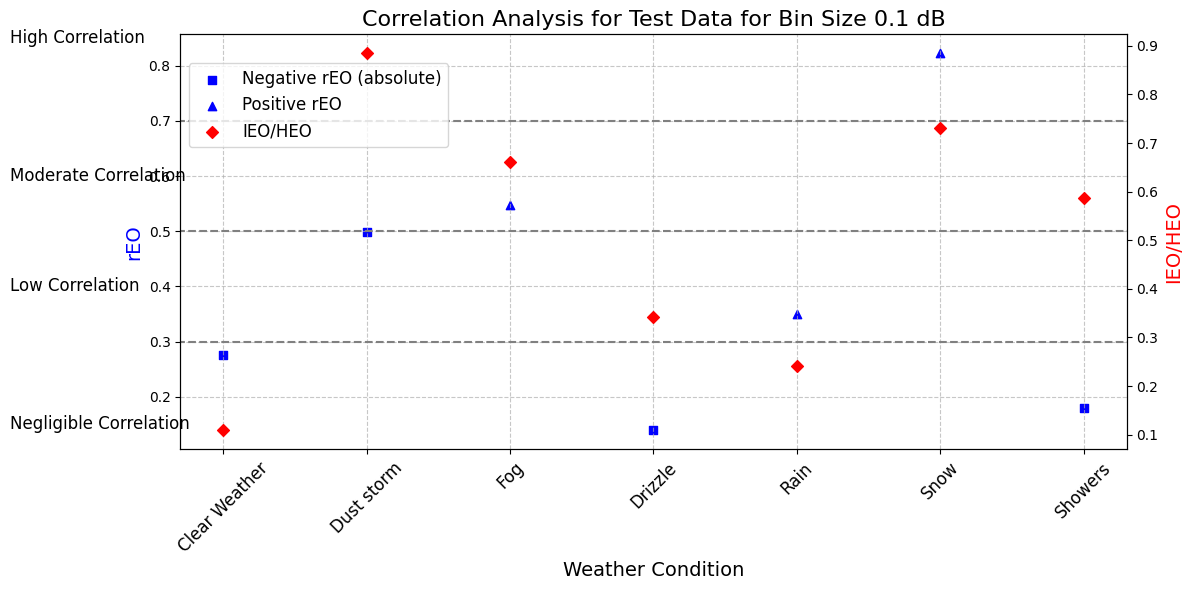

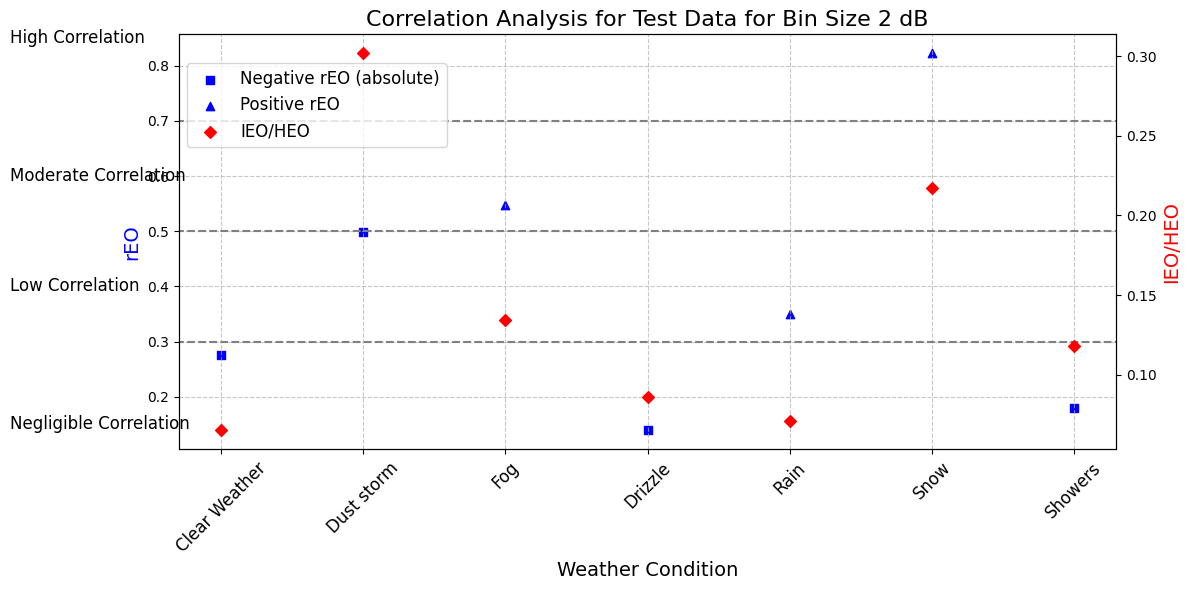

In [4]:
def plot_data_points(results_df, bin_size_label):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Create a secondary y-axis
    ax2 = ax1.twinx()

    # Separate the data for Negative rEO and Positive rEO
    negative_rEO = results_df[results_df['rEO'] < 0]
    positive_rEO = results_df[results_df['rEO'] >= 0]
    IEO_over_HEO = results_df['IEO/HEO']

    # Plot Negative rEO on ax1
    neg_scatter = ax1.scatter(negative_rEO.index, abs(negative_rEO['rEO']),
                              marker='s', color='blue', label='Negative rEO (absolute)')

    # Plot Positive rEO on ax1
    pos_scatter = ax1.scatter(positive_rEO.index, positive_rEO['rEO'],
                              marker='^', color='blue', label='Positive rEO')

    # Plot IEO/HEO on ax2
    IEO_scatter = ax2.scatter(results_df.index, IEO_over_HEO,
                               marker='D', color='red', label='IEO/HEO')

    # Add horizontal dashed lines for correlation regions on the left y-axis
    correlation_thresholds = [0.3, 0.5, 0.7]
    correlation_labels = ['Negligible Correlation', 'Low Correlation', 'Moderate Correlation', 'High Correlation']

    for threshold in correlation_thresholds:
        ax1.axhline(y=threshold, xmin=-0.05, xmax=1, color='gray',
                   linestyle='--', linewidth=1.5)

    # Add labels to the correlation regions
    ax1.text(-0.18, 0.15, correlation_labels[0],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.4, correlation_labels[1],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.6, correlation_labels[2],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')
    ax1.text(-0.18, 0.85, correlation_labels[3],
             transform=ax1.get_yaxis_transform(), fontsize=12,
             color='black', va='center')

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 0.95), fontsize=12)

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['Weather'], rotation=45, fontsize=12)

    # Set axis labels and title
    ax1.set_xlabel("Weather Condition", fontsize=14)
    ax1.set_ylabel("rEO", fontsize=14, color='blue')
    ax2.set_ylabel("IEO/HEO", fontsize=14, color='red')
    ax1.set_title(f"Correlation Analysis for Test Data for Bin Size {bin_size_label}", fontsize=16)

    # Enable grid on primary axis
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Plot for Bin Size 0.1 dB
plot_data_points(results_df_1, "0.1 dB")

# Plot for Bin Size 2 dB
plot_data_points(results_df_2, "2 dB")


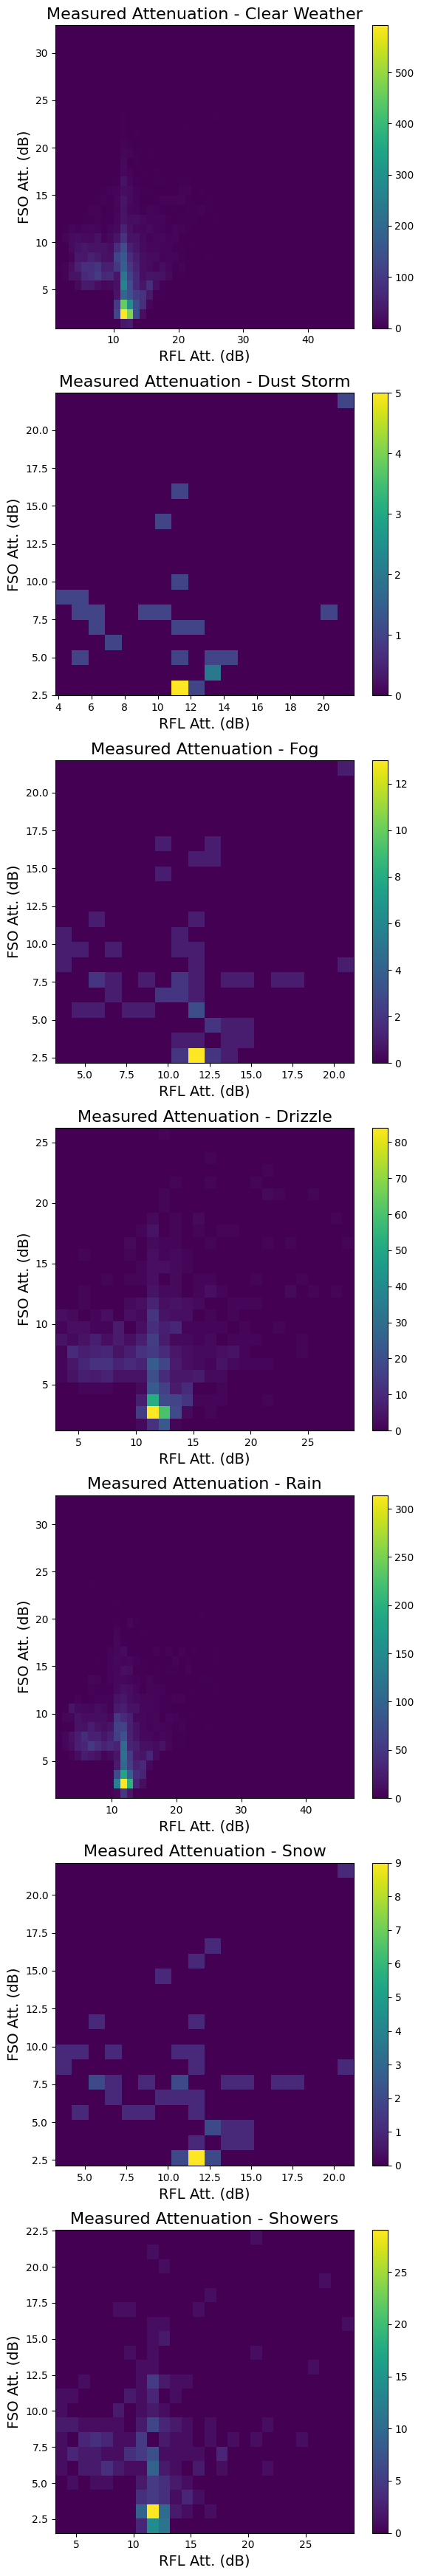

In [21]:
# Create a dictionary to hold test subsets based on SYNOP codes
test_fso_subsets = {}
test_rfl_subsets = {}
synop_codes_order = [0, 3, 4, 5, 6, 7, 8]
synop_code_labels = ['Clear Weather', 'Dust Storm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

# Reset indices for consistency
X_test = X_test.reset_index(drop=True)
X_test_fso = X_test_fso.reset_index(drop=True)
y_test_rfl = y_test_rfl.reset_index(drop=True)
y_test_fso = y_test_fso.reset_index(drop=True)


# Splitting test datasets by SYNOP code
for synop_code in synop_codes_order:
    test_rfl_subsets[synop_code] = X_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
    test_fso_subsets[synop_code] = X_test_fso[X_test_fso['SYNOPCode'] == synop_code].reset_index(drop=True)

# Function to plot heatmap with fixed axis limits and background for zero values
def plot_heatmap(x_data, y_data, title, ax, x_label='RFL Att. (dB)', y_label='FSO Att. (dB)'):
    heatmap = ax.hist2d(x_data, y_data, bins=[np.arange(min(x_data), max(x_data) + 1), np.arange(min(y_data), max(y_data) + 1)], cmap='viridis')
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    plt.colorbar(heatmap[3], ax=ax)

# Generate heat maps for each SYNOP code for test datasets
fig, ax = plt.subplots(7, figsize=(6,35))  # 7 rows, 2 columns
ax = ax.flatten()  # Flatten the array for easy indexing

for i, synop_code in enumerate(synop_codes_order):
    if not test_rfl_subsets[synop_code].empty:
        # Test data
        x_measured = y_test_rfl.iloc[test_rfl_subsets[synop_code].index]
        y_measured = y_test_fso.iloc[test_fso_subsets[synop_code].index]

        # Plot Measured Attenuation
        plot_heatmap(x_measured, y_measured, f'Measured Attenuation - {synop_code_labels[i]}', ax[i])

plt.tight_layout()
plt.show()
